In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from picosdk.discover import find_all_units
from picosdk.ps4000a import ps4000a as ps
from picosdk.functions import adc2mV, assert_pico_ok
import time

### 1. Find / Open the scope unit

In [2]:
# Handler and status
chandle = ctypes.c_int16()
status = {}
# Open PicoScope Series device
# Returns handle to chandle for use in future API functions
status["openunit"] = ps.ps4000aOpenUnit(ctypes.byref(chandle), None)

# Verifying pico is okay
try:
    assert_pico_ok(status["openunit"])
except:
    powerStatus = status["openunit"]

    if powerStatus == 286:
        status["changePowerSource"] = ps.ps4000aChangePowerSource(chandle, powerStatus)
    else:
        raise
    assert_pico_ok(status["changePowerSource"])

### 2. Channel Setting

In [3]:
# Channel Setting, Voltage range
ENABLED = 1
DISABLED = 0
ANALOGUE_OFFSET = 0.0
VOLTAGE_RANGE = 0  # +- 10mV

status["setChA"] = ps.ps4000aSetChannel(
    chandle,
    ps.PS4000A_CHANNEL["PS4000A_CHANNEL_A"],
    ENABLED,
    ps.PS4000A_COUPLING["PS4000A_DC"],
    VOLTAGE_RANGE,
    ANALOGUE_OFFSET,
)

assert_pico_ok(status["setChA"])

In [4]:
# Buffer size calculation
sizeOfOneBuffer = int(24e6)  # Size of buffer
numBuffersToCapture = 10
totalSamples = sizeOfOneBuffer * numBuffersToCapture

# Create buffers ready for assigning pointers for data collection
bufferAMax = np.zeros(shape=sizeOfOneBuffer, dtype=np.int16)
memory_segment = 0

# Set Data Buffers
status["setDataBuffersA"] = ps.ps4000aSetDataBuffers(
    chandle,
    ps.PS4000A_CHANNEL["PS4000A_CHANNEL_A"],
    bufferAMax.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
    None,
    sizeOfOneBuffer,
    memory_segment,
    ps.PS4000A_RATIO_MODE["PS4000A_RATIO_MODE_NONE"],
)
assert_pico_ok(status["setDataBuffersA"])

## 3. Streaming Mode

In [40]:
# Begin streaming mode:

# Time interval between data points. i.e., Sampling rate
interval_value = 50  # 80MSa/s
sampleInterval = ctypes.c_int32(interval_value)
sampleUnits = ps.PS4000A_TIME_UNITS["PS4000A_NS"]

# We are not triggering:
maxPreTriggerSamples = 0
autoStopOn = 1
downsampleRatio = 1  # No downsampling

# Run Straming
status["runStreaming"] = ps.ps4000aRunStreaming(
    chandle,
    ctypes.byref(sampleInterval),
    sampleUnits,
    maxPreTriggerSamples,
    totalSamples,
    autoStopOn,
    downsampleRatio,
    ps.PS4000A_RATIO_MODE["PS4000A_RATIO_MODE_NONE"],
    sizeOfOneBuffer,
)
assert_pico_ok(status["runStreaming"])

# We need a big buffer, not registered with the driver, to keep our complete capture in.
bufferCompleteA = np.zeros(shape=totalSamples, dtype=np.int16)
nextSample = 0
autoStopOuter = False
wasCalledBack = False


def streaming_callback(
    handle, noOfSamples, startIndex, overflow, triggerAt, triggered, autoStop, param
):
    global nextSample, autoStopOuter, wasCalledBack
    wasCalledBack = True
    destEnd = nextSample + noOfSamples
    sourceEnd = startIndex + noOfSamples
    bufferCompleteA[nextSample:destEnd] = bufferAMax[startIndex:sourceEnd]
    nextSample += noOfSamples
    if autoStop:
        autoStopOuter = True


# Convert the python function into a C function pointer.
cFuncPtr = ps.StreamingReadyType(streaming_callback)


# Fetch data from the driver in a loop, copying it out of the registered buffers and into our complete one.
while nextSample < totalSamples and not autoStopOuter:
    wasCalledBack = False
    status["getStreamingLastestValues"] = ps.ps4000aGetStreamingLatestValues(
        chandle, cFuncPtr, None
    )
    if not wasCalledBack:
        # If we weren't called back by the driver, this means no data is ready. Sleep for a short while before trying
        # again.
        time.sleep(0.01)

print("Done grabbing values.")


# Find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps4000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])


# Convert ADC counts data to mV
raw_datas = bufferCompleteA * 10 / maxADC.value
print("Done converting values.")

rmses = []
spacing = np.linspace(sizeOfOneBuffer, totalSamples, numBuffersToCapture, dtype=int)
for i in spacing:
    if i == spacing[0]:
        raw_slicing = raw_datas[:i]
        rmses.append(np.sqrt((raw_slicing**2).mean()))
    else:
        raw_slicing = raw_datas[i - spacing[0] : i]
        rmses.append(np.sqrt((raw_slicing**2).mean()))

print("done")

Done grabbing values.
Done converting values.
done


In [44]:
np.array(rmses).mean()

0.10144092754777326

In [38]:
np.linspace(24e6, 24e7, 10, dtype=int)

array([ 24000000,  48000000,  72000000,  96000000, 120000000, 144000000,
       168000000, 192000000, 216000000, 240000000])

In [32]:
spacing = 

In [36]:
raw_datas[int(spacing[-2]) : int(spacing[-1])].shape

(24000000,)

In [23]:
raw_datas.shape

(240000000,)

In [27]:
240000000 == 24e7

True

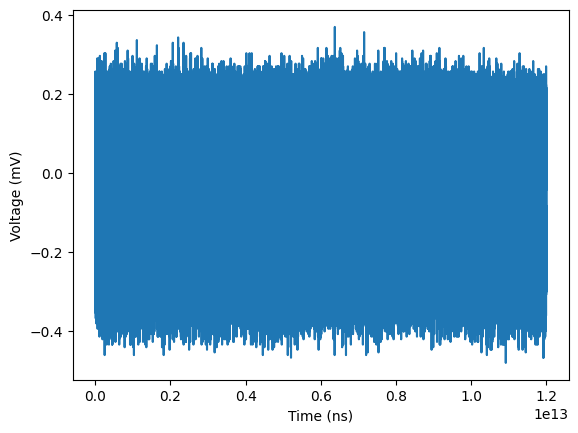

{'openunit': 0, 'setChA': 0, 'setDataBuffersA': 0, 'runStreaming': 0, 'getStreamingLastestValues': 0, 'maximumValue': 0, 'stop': 0, 'close': 0}


In [6]:
# Plotting

actualSampleInterval = sampleInterval.value
actualSampleIntervalNs = actualSampleInterval * 1000
# Create time data
time = np.linspace(0, (totalSamples - 1) * actualSampleIntervalNs, totalSamples)

# Plot data from channel A and B
plt.plot(time, raw_datas[:])
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (mV)")
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps4000aStop(chandle)
assert_pico_ok(status["stop"])

# Disconnect the scope
# handle = chandle
status["close"] = ps.ps4000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# Display status returns
print(status)